# MSSE 277B: Machine Learning Algorithms
# Homework assignment #11 (extra credit) VAE
## Assigned Apr. 20 and Due May 2.
### Student Name: Charis Liao


## 1. Variational Autoencoder(VAE) applied to MNIST dataset.
Train an VAE model for the MNIST dataset. The encoder and decoder of the VAE model are multilayer perceptron. Encoder have hidden layer size of (256,128) and the decoder is the reverse of that. In the bottleneck region, the encoder output is mapped to two latent vector  and  each represented with 32 hidden neurons. Then the latent state z with 32 hidden neurons is formulated by applying reparameterization with addition of noise , which is then passed to decoder. Use binary cross entropy plus KL divergence as your loss function. Train this model with the MNIST dataset and use the provided reconstruction code to show that your model is able to reproduce the images.

In [1]:
# Import modules 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import wraps
from time import time
from torch import nn
from torchsummary import summary
import torch
from torch.optim import SGD, Adam
import torch.nn.functional as F
import random
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split, KFold
%matplotlib inline

/opt/anaconda3/envs/msse-python/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# import dataset 
df = pd.read_pickle('mnist.pkl')

In [3]:
# Normalize the entire data set
x_train = df[0][0] / 255.0
y_train = df[0][1]
x_test = df[1][0] / 255.0
y_test = df[1][1] 

len(x_train[0][0])

32

In [4]:
def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        print('func:%r  took: %2.4f sec' % (f.__name__,  te-ts))
        return result
    return wrap

In [63]:
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 1024), size_average=False)

    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [74]:
def data_gen(X,y, batchsize):
    '''
    Generator for data
    '''
    for i in range(len(X)//batchsize):
        yield X[i*batchsize:(i+1)*batchsize],y[i*batchsize:(i+1)*batchsize]
    i+=1
    yield X[i*batchsize:],y[i*batchsize:]
        

class Trainer():
    def __init__(self, model, optimizer_type, learning_rate, epoch, batch_size, input_transform=lambda x: x,):
        """ The class for training the model
        model: nn.Module
            A pytorch model
        optimizer_type: 'adam' or 'sgd'
        learning_rate: float
        epoch: int
        batch_size: int
        input_transform: func
            transforming input. Can do reshape here
        """
        self.model = model

        if optimizer_type == "sgd":
            self.optimizer = SGD(model.parameters(), learning_rate,momentum=0.9)
        elif optimizer_type == "adam":
            self.optimizer = Adam(list(model.parameters()), learning_rate)
        elif optimizer_type == 'adam_l2':
            self.optimizer = Adam(model.parameters(), learning_rate, weight_decay=1e-5)
            
        self.epoch = epoch
        self.batch_size = batch_size
        self.input_transform = input_transform


    @timing
    def train(self, inputs, outputs, val_inputs, val_outputs,draw_curve=False,early_stop=False,l2=False,silent=False):
        """ train self.model with specified arguments
        inputs: np.array, The shape of input_transform(input) should be (ndata,nfeatures)
        outputs: np.array shape (ndata,)
        val_nputs: np.array, The shape of input_transform(val_input) should be (ndata,nfeatures)
        val_outputs: np.array shape (ndata,)
        early_stop: bool
        l2: bool
        silent: bool. Controls whether or not to print the train and val error during training
        """
        inputs = self.input_transform(torch.tensor(inputs, dtype=torch.float))
        outputs = torch.tensor(outputs, dtype=torch.int64)
        val_inputs = self.input_transform(torch.tensor(val_inputs, dtype=torch.float))
        val_outputs = torch.tensor(val_outputs, dtype=torch.int64)

        losses = []
        val_losses = []
        weights = self.model.state_dict()
        lowest_val_loss = np.inf
        
        for n_epoch in tqdm(range(self.epoch), leave=False):
            self.model.train()
            #shuffle the data in each epoch
            idx =torch.randperm(inputs.size()[0])
            inputs=inputs[idx]
            outputs=outputs[idx]
            train_gen = data_gen(inputs,outputs,self.batch_size)
            
            epoch_loss = 0

            for batch_input,batch_output in train_gen:
                batch_importance = len(batch_output) / len(outputs)
                batch_predictions, mu, logvar = self.model(batch_input)
                

                loss = loss_fn(batch_predictions, batch_input, mu, logvar)
                if l2:
                    l2_lambda = 1e-5
                    l2_norm = sum(p.pow(2.0).sum() for p in self.model.parameters())
                    loss = loss + l2_lambda * l2_norm
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.detach().cpu().item() /self.batch_size * batch_importance
                
            val_loss = self.evaluate(val_inputs, val_outputs, print_loss=False)
            if n_epoch % 10 ==0 and not silent: 
                print("Epoch %d/%d - Loss: %.3f " % (n_epoch + 1, self.epoch, epoch_loss))
                print("              Val_loss: %.3f" % (val_loss))
            losses.append(epoch_loss)
            val_losses.append(val_loss)
            if early_stop:
                if val_loss < lowest_val_loss:
                    lowest_val_loss = val_loss
                    weights = self.model.state_dict()
        
        if draw_curve:
            plt.figure()
            plt.plot(np.arange(self.epoch) + 1,losses,label='Training loss')
            plt.plot(np.arange(self.epoch) + 1,val_losses,label='Validation loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
        
        if early_stop:
            self.model.load_state_dict(weights)    

        return {"losses": losses,  "val_losses": val_losses}
        
    def evaluate(self, inputs, outputs, print_loss=True):
        if torch.is_tensor(inputs):
            inputs = self.input_transform(inputs)
        else:
            inputs = self.input_transform(torch.tensor(inputs, dtype=torch.float))
            outputs = torch.tensor(outputs, dtype=torch.int64)
        self.model.eval()
        gen = data_gen(inputs,outputs,self.batch_size)
        losses = 0

        for batch_input,batch_output in gen:
            batch_importance = len(batch_output) / len(outputs)
            with torch.no_grad():
                batch_predictions, mu, logvar = self.model(batch_input)
                loss= loss_fn(batch_predictions, batch_input, mu, logvar)
                
            losses += loss.detach().cpu().item()/self.batch_size * batch_importance

        if print_loss:
            print("Loss: %.3f" % losses)
        return losses

In [75]:
from sklearn.model_selection import train_test_split, KFold
from torchsummary import summary
def train_model(Xs,ys,test_Xs,test_ys,epochs,draw_curve=True,early_stop=False,batchsize=128, optimizer='adam',lr=1e-3,l2=False,input_shape=lambda x: x.reshape([-1, x_dim])):
    train_Xs, val_Xs, train_ys, val_ys = train_test_split(Xs, ys, test_size=1/3, random_state=0)
    x_train_tensor = torch.tensor(train_Xs, dtype = torch.float32)
    
    x_dim, h_dim1, h_dim2, z_dim = 32*32, 256, 128, 32
    model=VAE(x_dim, h_dim1, h_dim2, z_dim)
    summary(model,input_shape[1:])

    print(f"{VAE.__name__} parameters:", sum([len(item.flatten()) for item in model.parameters()]))
    trainer = Trainer(model, optimizer, lr, epochs, batchsize, lambda x: x.reshape(input_shape))
    log=trainer.train(train_Xs, train_ys,val_Xs,val_ys,early_stop=early_stop,l2=l2)

    if draw_curve:
        plt.figure()
        plt.plot(log["losses"], label="losses")
        plt.plot(log["val_losses"], label="validation_losses")
        plt.legend()
        plt.title(f'loss')

    # Report result for this fold
    if early_stop:
        report_idx= np.argmin(log["val_losses"])      
    else:
        report_idx=-1
    test_loss=trainer.evaluate(test_Xs,test_ys,print_loss=False)
    print("Test loss:",test_loss)
    return model

In [76]:
def reconstruct(vae,data_gen):
    """given a VAE model, plot original data and reconstructed data from VAE"""
    inp = next(data_gen)[0]
    print('Original Data:')
    plot_digits(inp)
    with torch.no_grad():
        reconst,mu,log_var = vae(torch.tensor(inp,dtype=torch.float))

    print('Reconstructed Data:')
    plot_digits(reconst.detach().numpy()) 
    
def plot_digits(data):
    #plot 100 digit. data shape(100,32,32)
    fig, ax = plt.subplots(10, 10, figsize=(12, 12),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(32, 32), cmap=plt.get_cmap('gray'))
        im.set_clim(0, 1)



In [77]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim) #mean
        self.fc32 = nn.Linear(h_dim2, z_dim) #variance
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def bottleneck(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps * std + mu # return z sampled
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        # go through the encoder to output mu 
        mu, log_var = self.encoder(x.view(-1, 1024))
        z = self.bottleneck(mu, log_var)
        return self.decoder(z), mu, log_var



<class 'generator'>
Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 256]                 262,400
├─Linear: 1-2                            [-1, 128]                 32,896
├─Linear: 1-3                            [-1, 32]                  4,128
├─Linear: 1-4                            [-1, 32]                  4,128
├─Linear: 1-5                            [-1, 128]                 4,224
├─Linear: 1-6                            [-1, 256]                 33,024
├─Linear: 1-7                            [-1, 1024]                263,168
Total params: 603,968
Trainable params: 603,968
Non-trainable params: 0
Total mult-adds (M): 0.60
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.30
Estimated Total Size (MB): 2.32
VAE parameters: 603968


  2%|▏         | 1/50 [00:04<03:37,  4.45s/it]

Epoch 1/50 - Loss: 196.653 
              Val_loss: 135.206


 22%|██▏       | 11/50 [00:52<02:59,  4.60s/it]

Epoch 11/50 - Loss: 70.794 
              Val_loss: 71.170


 42%|████▏     | 21/50 [01:39<02:14,  4.63s/it]

Epoch 21/50 - Loss: 64.184 
              Val_loss: 65.296


 62%|██████▏   | 31/50 [02:26<01:23,  4.40s/it]

Epoch 31/50 - Loss: 61.645 
              Val_loss: 63.060


 82%|████████▏ | 41/50 [03:14<00:41,  4.59s/it]

Epoch 41/50 - Loss: 60.062 
              Val_loss: 61.480


func:'train'  took: 244.9695 sec
Test loss: 60.1344748161316


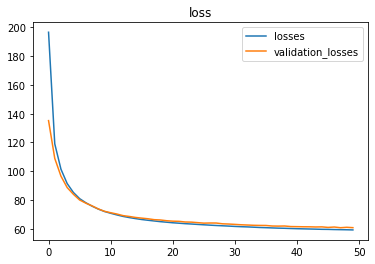

In [79]:
# vae = VAE(256, 128, 32, 32)

x_dim, h_dim1, h_dim2, z_dim = 32*32, 256, 128, 32  # example values
vae = VAE(x_dim, h_dim1, h_dim2, z_dim)  # create instance of VAE with desired dimensions
print(type(vae.parameters()))

trained_model = train_model(x_train, y_train, x_test, y_test, 50, draw_curve=True, early_stop=False, batchsize=128, optimizer='adam', lr=1e-3, l2=False, input_shape=(-1, x_dim))


In [80]:
data_gen = data_gen(x_train,y_train, 128)

Original Data:
Reconstructed Data:


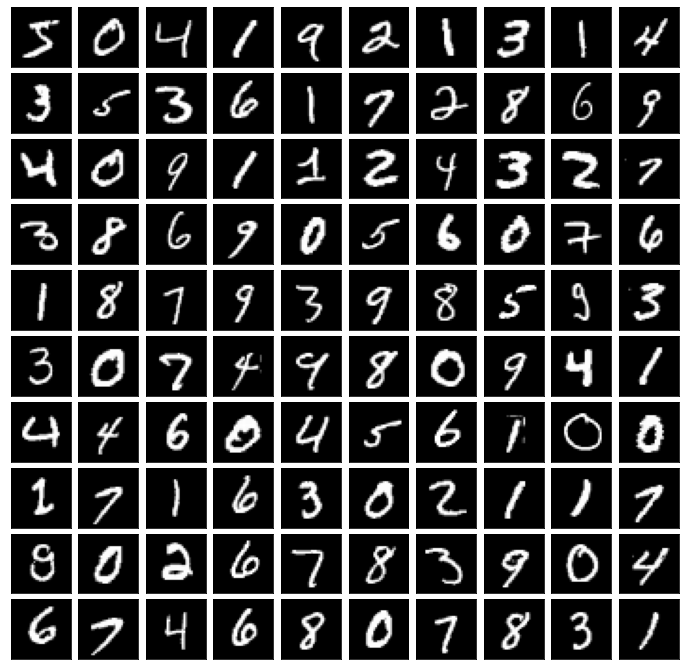

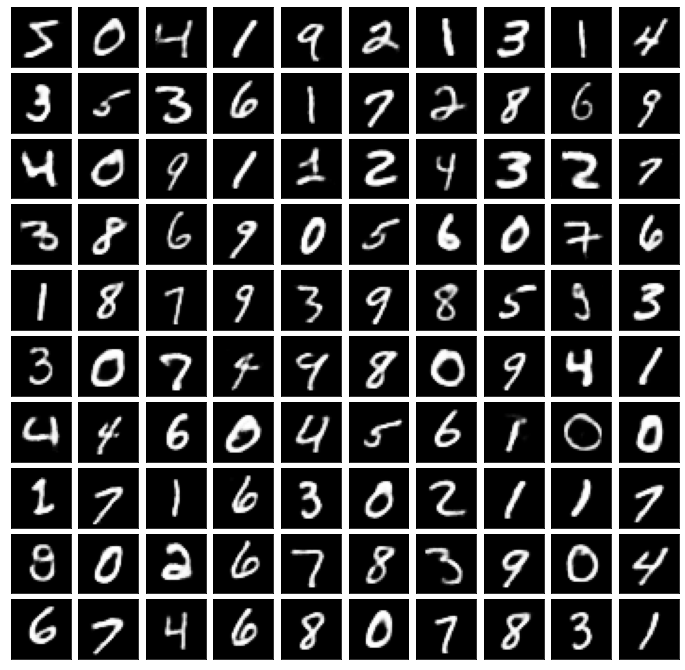

In [81]:
reconstruct(trained_model,data_gen)

# You've reached the end of homework 11 
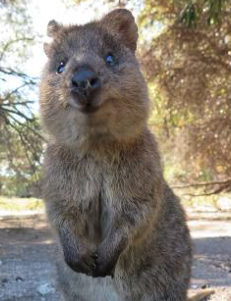